# 1. Importing Libraries

In [681]:
import pandas as pd 
import numpy as np 
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split 
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from BorutaShap import BorutaShap
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score, plot_confusion_matrix

# 2. Reading Data

In [682]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df



def read_target():
    path = 'secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#for the testing purporse, trim to remain first 100 rows only
X = read_features()
y = read_target().iloc[:,0]

In [683]:
#Row & Columns of Features 
X.shape

(1567, 590)

# 3. Splitting Training & Testing Data

In [684]:
#Splitting the Data: 80% Training, 20% Testing Data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

In [685]:
#Rows and Columns of X_Train DF
x_train.shape

(1253, 590)

In [686]:
#Rows and Columns of X_Train DF
x_test.shape

(314, 590)

# 4. Reducing Dimensionality

## 4.1. Remove duplicated Columns

In [687]:
#Function for finding and removing duplicated columns (features)
def remove_duplicated_columns(df):
    dict_duplicate_pair = {}
    dict_duplicate_matches = {}
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            dict_duplicate_pair[str(i+1)+';'+str(j+1)] = df.iloc[:,i].equals(df.iloc[:,j])
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)
        if len(l)!=0:
            dict_duplicate_matches[i] = l


    df_duplicate_pair = pd.DataFrame.from_dict(dict_duplicate_pair, orient='index')
    df_duplicate_pair.columns=['duplicate']

    df_duplicate_matches = pd.DataFrame.from_dict(dict_duplicate_matches, orient='index')

    
    df = df.drop(columns=to_remove, axis = 1)

    return df

In [688]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_duplicated_columns(x_train)
x_train.shape

(1253, 486)

## 4.2. Removing Features with Constant Volatility

In [689]:
#Defining function to find and remove features with zero standard deviation 
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

In [690]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_constant_volatility(x_train)
x_train.shape

(1253, 474)

## 4.3. Remove Features with high % of Missing Values

In [691]:
#Defining function to remove features with a given % of missing values 
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

In [692]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_cols_with_high_pct_null(x_train, 0.7)
x_train.shape

(1253, 466)

# 5. Outlier & Missing Value Treatment

In [693]:
#Definition of Functiom
def outlier_clamp(df):
    for col in df.columns:
        ll_col = df[col].mean() - 2 * df[col].std()
        ul_col = df[col].mean() + 2 * df[col].std()
        df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

In [694]:
x_train = outlier_clamp(x_train)

In [695]:
#KNN only distance
def knndistance(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation 
    knn = KNNImputer(n_neighbors=3, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

In [696]:
x_train = knndistance(x_train)

#Function to drop Outliers and impute Missing Values with KNN 
def outlierknn(df):
    #Outlier treatment first:
    for col in df.columns:
          ll_col = df[col].mean() - 3 * df[col].std()
          ul_col = df[col].mean() + 3 * df[col].std()
          df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
    #Scaling data 
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation
    knn = KNNImputer(n_neighbors=3, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

#Using function above on x_train
x_train = outlierknn(x_train)

# 6. Feature Selection

In [697]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y,method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [698]:
x_train = BorutaShap_FS(x_train,y_train,'shap')

  0%|          | 0/100 [00:00<?, ?it/s]

In [699]:
#Shape of x_train after Feature Selection
x_train.shape

(1253, 16)

In [700]:
#Correlation Matrix of Remaining Features
x_train.corr()

,feature_478,feature_206,feature_60,feature_283,feature_34,feature_66,feature_342,feature_124,feature_299,feature_349,feature_65,feature_435,feature_185,feature_164,feature_332,feature_442
feature_478,1.000000,0.991256,0.225559,0.104229,0.088437,0.070689,0.972405,-0.017736,-0.001642,0.054413,0.002212,0.012037,0.010467,-0.001121,-0.075356,0.070135
feature_206,0.991256,1.000000,0.222066,0.109558,0.086359,0.064494,0.971257,-0.014702,-0.000171,0.058856,-0.002626,0.014332,0.011152,0.000300,-0.077851,0.078312
feature_60,0.225559,0.222066,1.000000,0.234082,0.151002,-0.367314,0.212905,0.058494,0.101639,0.262599,-0.441977,0.154459,0.001145,0.094163,-0.013010,0.115579
feature_283,0.104229,0.109558,0.234082,1.000000,0.015529,0.025996,0.108079,0.018306,0.007369,0.148088,0.010713,0.065387,-0.048790,0.000615,-0.010785,0.038043
feature_34,0.088437,0.086359,0.151002,0.015529,1.000000,0.077402,0.095569,0.081974,-0.030060,0.078712,0.070404,0.014667,-0.036640,-0.031574,0.018647,-0.171773
feature_66,0.070689,0.064494,-0.367314,0.025996,0.077402,1.000000,0.078139,-0.074345,0.097826,0.038341,0.929920,0.122255,0.012727,0.076127,-0.100633,0.000788
feature_342,0.972405,0.971257,0.212905,0.108079,0.095569,0.078139,1.000000,-0.029583,0.001001,0.050799,0.015506,0.012521,0.012152,0.002458,-0.098796,0.069718
feature_124,-0.017736,-0.014702,0.058494,0.018306,0.081974,-0.074345,-0.029583,1.000000,-0.010214,0.015154,-0.069254,-0.005769,-0.012430,-0.005776,0.083735,0.027781
feature_299,-0.001642,-0.000171,0.101639,0.007369,-0.030060,0.097826,0.001001,-0.010214,1.000000,0.053644,0.079686,0.872580,-0.010433,0.988120,-0.039670,-0.050088
feature_349,0.054413,0.058856,0.262599,0.148088,0.078712,0.038341,0.050799,0.015154,0.053644,1.000000,0.011105,0.096147,0.020086,0.045489,-0.058517,0.020348


Text(0.5, 1.0, 'Correlation of remaining Features')

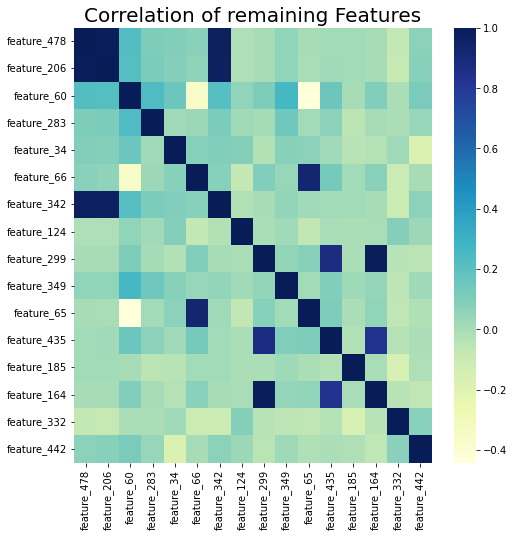

In [701]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

# 7. Multicolinearity Treatment

In [702]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):


    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                #Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [703]:
x_train=remove_collinear_features(x_train, 0.7)
x_train.shape

(1253, 11)

Text(0.5, 1.0, 'Correlation of remaining Features')

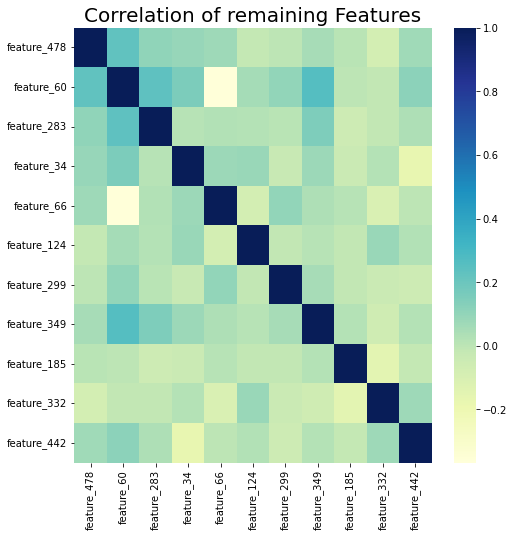

In [704]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

# 8. Balancing

In [705]:
#Function SMOTEENN
def sampling(X_train, y_train):
    sampler = SMOTEENN(random_state=100)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

In [706]:
x_train, y_train = sampling(x_train, y_train)

In [707]:
x_train.shape

(1665, 11)

In [708]:
y_train.shape

(1665,)

# 9. Modeling

In [709]:
#Turning y_train to categorical, since Naive Bayes works better on categorical data
y_train = pd.Categorical(y_train)

In [710]:
y_train = pd.DataFrame(y_train)
y_train

,0
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
1660,1
1661,1
1662,1
1663,1


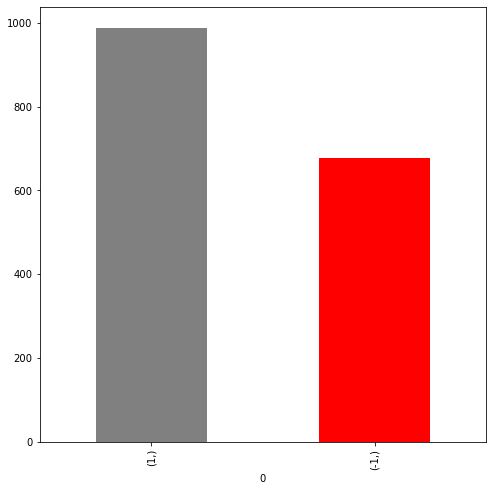

In [711]:
y_train.value_counts().plot.bar(color = ['grey', 'red'])
plt.show()

In [712]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
# make predictions
expected = y_train
predicted = gnb.predict(x_train)
# summarize the fit of the gnb
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


              precision    recall  f1-score   support

          -1       0.63      0.82      0.71       677
           1       0.85      0.68      0.75       988

    accuracy                           0.73      1665
   macro avg       0.74      0.75      0.73      1665
weighted avg       0.76      0.73      0.74      1665

[[555 122]
 [321 667]]


In [713]:
cf_matrix = confusion_matrix(expected, predicted)
sensitivity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
sensitivity

0.6751012145748988

# 10. Test Data

In [714]:
#1. Remove Duplicated Columns 
x_test = remove_duplicated_columns(x_test)
x_test.shape

(314, 480)

In [715]:
#2. Remove Constant Volalitily
x_test = remove_constant_volatility(x_test)
x_test.shape

(314, 468)

In [716]:
#3. Remove High % of NA
x_test = remove_cols_with_high_pct_null(x_test, 0.6)
x_test.shape

(314, 444)

In [717]:
#4. Drop Outliers and KNN Imputation
x_test= outlierknn(x_test)

In [718]:
#5. Take the same Columns as in train data 
columns_list = x_train.columns
x_test = x_test.loc[:,columns_list]
x_test.shape

(314, 11)

In [719]:
#6. Balancing Again 
#x_test, y_test = sampling(x_test, y_test)

In [720]:
#6. Change Target Variable to Categorical
y_test = pd.Categorical(y_test)
y_test = pd.DataFrame(y_test)
y_test

,0
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
309,-1
310,-1
311,-1
312,-1


In [721]:
exp_test = y_test
pred_test = gnb.predict(x_test)
# summarize the fit of the gnb
print(metrics.classification_report(exp_test, pred_test))
print(metrics.confusion_matrix(exp_test, pred_test))

              precision    recall  f1-score   support

          -1       0.97      0.77      0.86       293
           1       0.16      0.62      0.25        21

    accuracy                           0.76       314
   macro avg       0.56      0.69      0.56       314
weighted avg       0.91      0.76      0.82       314

[[225  68]
 [  8  13]]


In [722]:
cf_matrix_test = confusion_matrix(exp_test, pred_test)
sensitivity_test = cf_matrix_test[1][1] / ( cf_matrix_test[1][1] + cf_matrix_test[1][0] )
sensitivity_test

0.6190476190476191

In [723]:
#Accuracy score
accuracy_score(exp_test, pred_test)

0.7579617834394905

In [724]:
#Recall score
recall_score(exp_test, pred_test)

0.6190476190476191